
## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Loading and Visualizing the Dataset

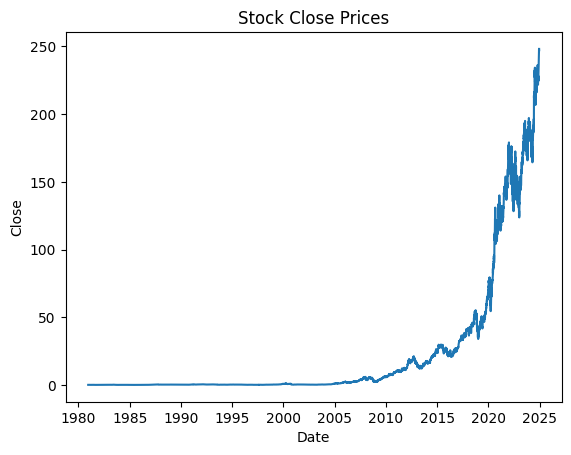

In [5]:
df = pd.read_csv(r"C:\Users\raomu\.cache\kagglehub\datasets\mianbilal12\apple-stock-market-data-19802024\versions\1\AAPL_historical_data.csv",
                 parse_dates=True, index_col='Date')

sns.lineplot(data=df, x=df.index, y='Close')
plt.title("Stock Close Prices")
plt.show()

## Data Preprocessing

In [6]:
print(df.head())
print(df.info())

                               Open      High       Low     Close
Date                                                             
1980-12-12 00:00:00-05:00  0.098834  0.099264  0.098834  0.098834
1980-12-15 00:00:00-05:00  0.094108  0.094108  0.093678  0.093678
1980-12-16 00:00:00-05:00  0.087232  0.087232  0.086802  0.086802
1980-12-17 00:00:00-05:00  0.088951  0.089381  0.088951  0.088951
1980-12-18 00:00:00-05:00  0.091530  0.091959  0.091530  0.091530
<class 'pandas.core.frame.DataFrame'>
Index: 11094 entries, 1980-12-12 00:00:00-05:00 to 2024-12-13 00:00:00-05:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    11094 non-null  float64
 1   High    11094 non-null  float64
 2   Low     11094 non-null  float64
 3   Close   11094 non-null  float64
dtypes: float64(4)
memory usage: 691.4+ KB
None


## Stationarity Check with ADF Test

In [7]:
result = adfuller(df['Close'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] > 0.05:
    print("The series is non-stationary.")
    df['Close_diff'] = df['Close'].diff().dropna()
    print("First-order differencing applied.")
else:
    print("The series is stationary.")

ADF Statistic: 4.8347574190704865
p-value: 1.0
The series is non-stationary.
First-order differencing applied.


## Plot ACF and PACF

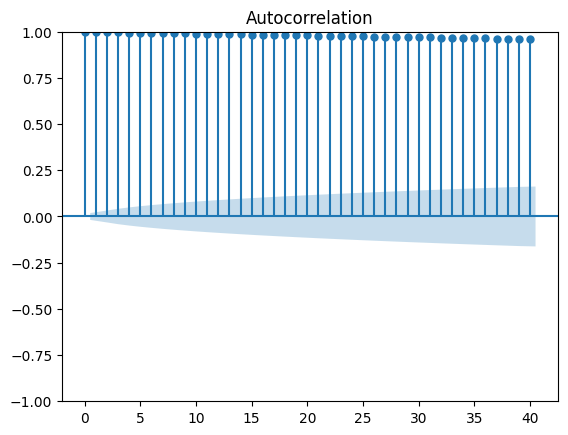

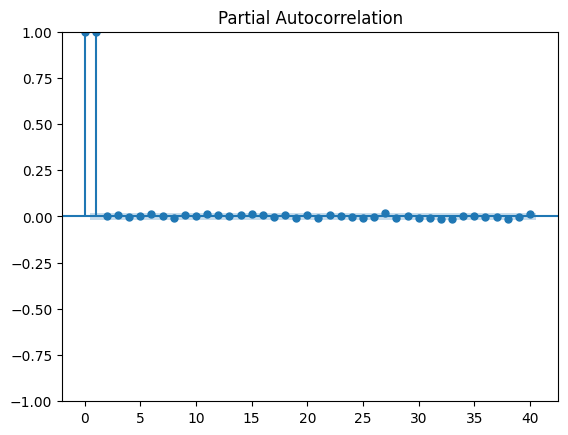

In [8]:
plot_acf(df['Close'].dropna(), lags=40)
plot_pacf(df['Close'].dropna(), lags=40)
plt.show()


## Heatmap of Correlations

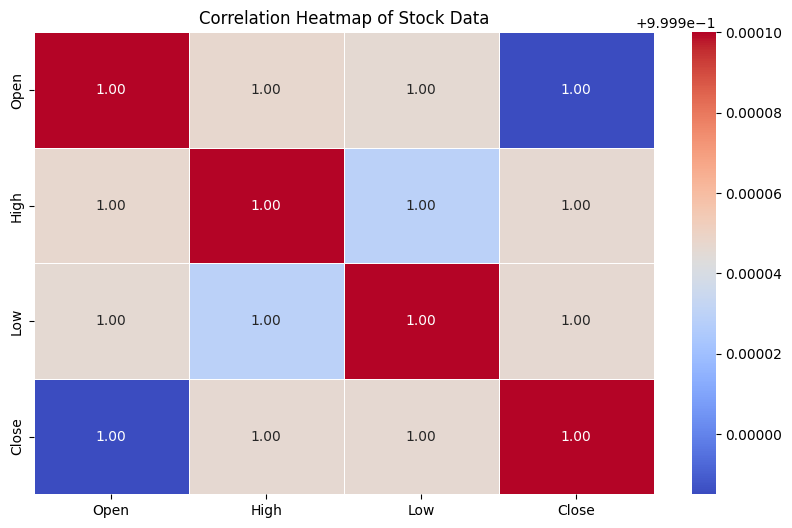

In [9]:
correlation_matrix = df[['Open', 'High', 'Low', 'Close']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Stock Data')
plt.show()

## ARIMA Model

In [10]:
model = ARIMA(df['Close'], order=(2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                11094
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -14791.768
Date:                Sat, 28 Dec 2024   AIC                          29593.536
Time:                        10:40:18   BIC                          29630.106
Sample:                             0   HQIC                         29605.851
                              - 11094                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6954      0.087      7.966      0.000       0.524       0.867
ar.L2         -0.4979      0.070     -7.143      0.000      -0.635      -0.361
ma.L1         -0.7078      0.088     -8.023      0.0

## Residuals and Forecast Visualization (ARIMA)

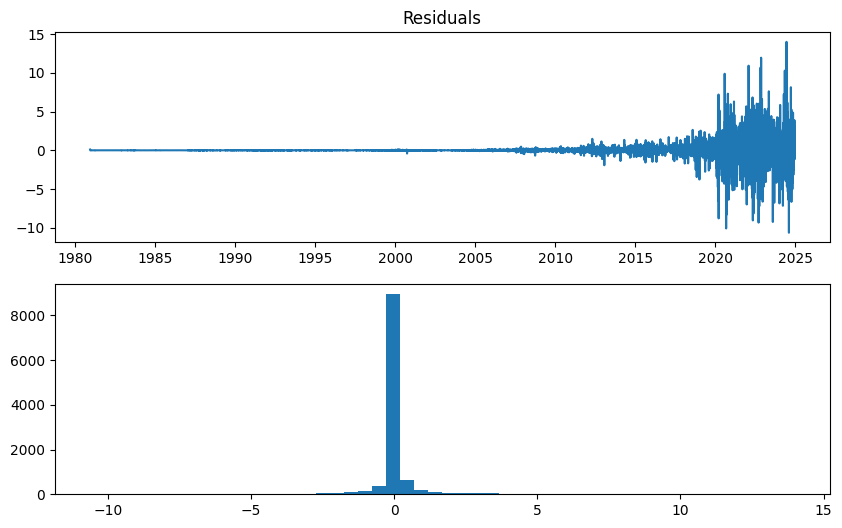

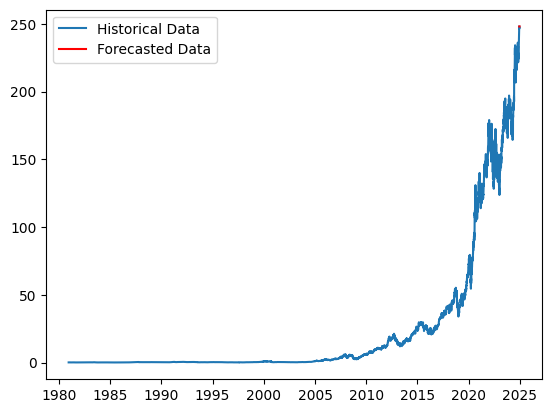

In [11]:
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(212)
plt.hist(residuals, bins=50)
plt.show()

forecast = model_fit.forecast(steps=10)
plt.plot(df.index, df['Close'], label='Historical Data')
plt.plot(pd.date_range(df.index[-1], periods=10, freq='D'), forecast, label='Forecasted Data', color='red')
plt.legend()
plt.show()

## Scaling and Creating Sequences for LSTM

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close_scaled'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 50
X, y = create_sequences(df['Close_scaled'].values, sequence_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Building and Training LSTM Model

In [13]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 4.7718e-05 - val_loss: 0.0011
Epoch 2/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 1.6834e-06 - val_loss: 4.3084e-04
Epoch 3/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 2.4323e-06 - val_loss: 0.0023
Epoch 4/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - loss: 2.1204e-06 - val_loss: 4.8148e-04
Epoch 5/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - loss: 2.2996e-06 - val_loss: 0.0014
Epoch 6/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - loss: 1.4665e-06 - val_loss: 9.6450e-04
Epoch 7/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - loss: 1.6465e-06 - val_loss: 5.3203e-04
Epoch 8/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - loss: 1.8540e-06 - val_loss: 4.1871e-04
Epoch 9/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 1.3293e-06 - val_loss: 7.2316e-04
Epoch 10/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - loss: 1.5222e-06 - val_loss: 4.0391e-04
Epoch 11/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/ste

## Loss Visualization


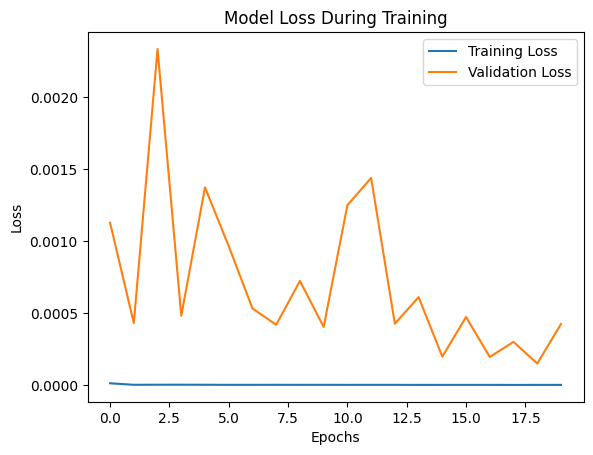

In [14]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

 ## LSTM Predictions vs True Prices

70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


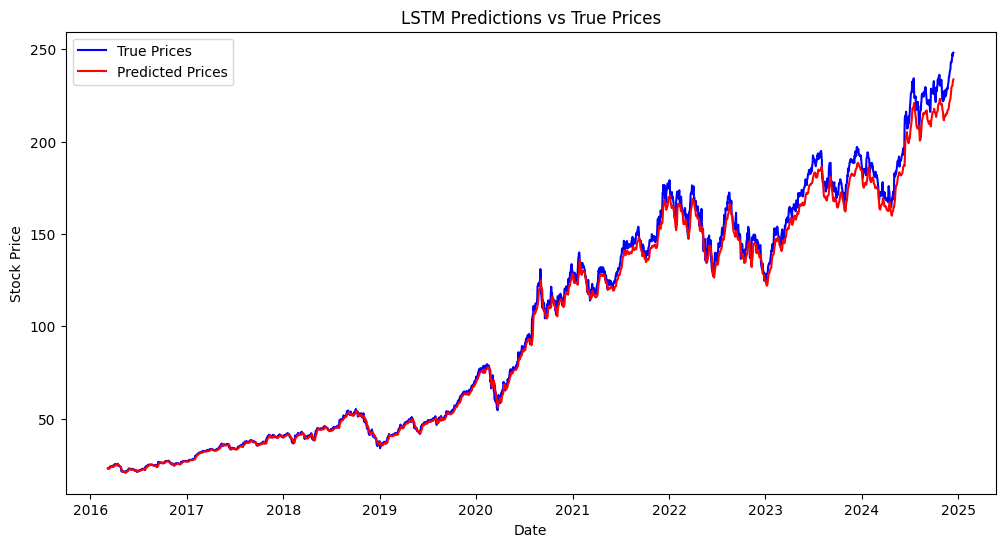

In [15]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_unscaled, label='True Prices', color='blue')
plt.plot(df.index[-len(y_test):], predictions, label='Predicted Prices', color='red')
plt.title("LSTM Predictions vs True Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

## Metrics Calculation for ARIMA

In [16]:
actual_arima = df['Close'][-len(model_fit.fittedvalues):]
predicted_arima = model_fit.fittedvalues

mse_arima = mean_squared_error(actual_arima, predicted_arima)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(actual_arima, predicted_arima)

print(f"ARIMA Model Metrics:")
print(f"MSE: {mse_arima}")
print(f"RMSE: {rmse_arima}")
print(f"MAE: {mae_arima}")

ARIMA Model Metrics:
MSE: 0.8427362583799484
RMSE: 0.918006676653252
MAE: 0.2967112208884575


## Prophet Forecasting

10:47:09 - cmdstanpy - INFO - Chain [1] start processing
10:47:11 - cmdstanpy - INFO - Chain [1] done processing


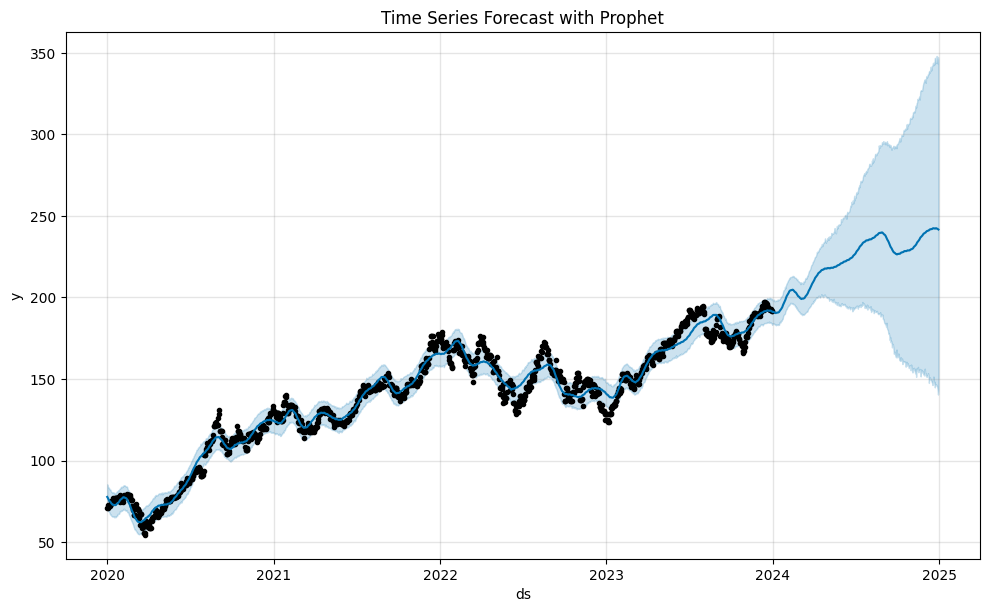

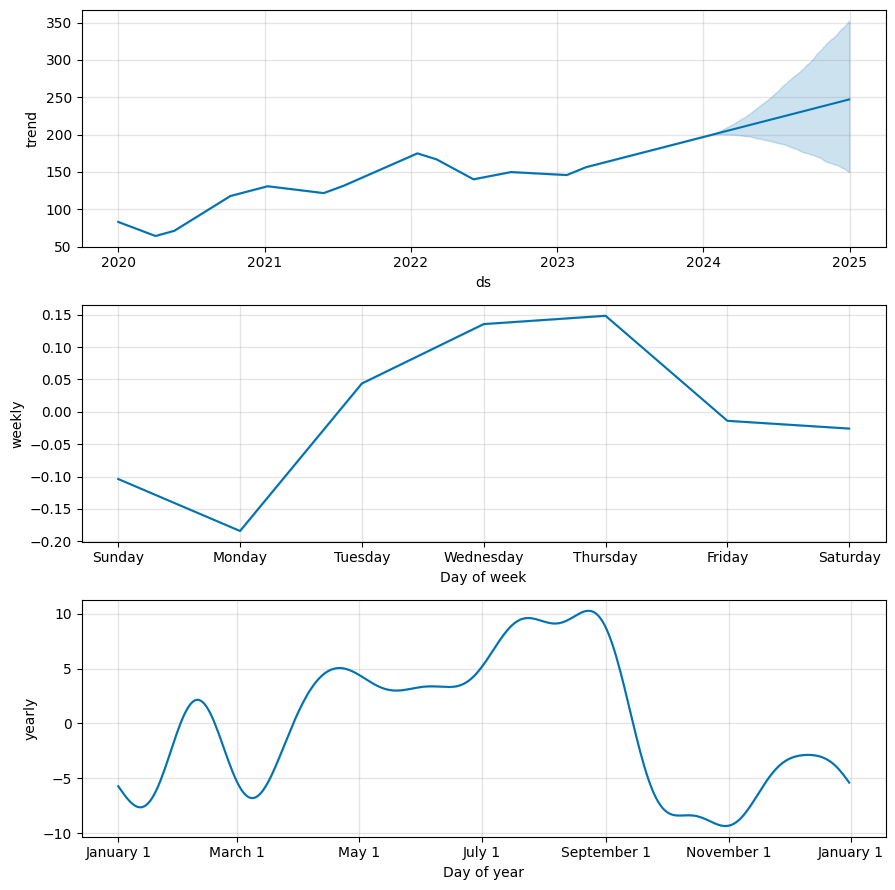

In [18]:
# Create the date range for the forecast period
dates = pd.date_range(start='2020-01-01', end='2023-12-31', freq='D')

# Convert dates to timezone-aware to match df index
dates = dates.tz_localize('UTC')

# Create the df for Prophet
# Reindex df['Close'] to match the 'dates' index and forward fill missing values
df_prophet = pd.DataFrame({'ds': dates, 'y': df['Close'].reindex(dates, method='ffill')})

# Remove timezone information from 'ds' column
df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None)

# Initialize Prophet model with seasonality options
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Fit the model with the data
model_prophet.fit(df_prophet)

# Create a future dataframe for forecasting
future_dates = model_prophet.make_future_dataframe(periods=365)  # Adding 365 days of forecast

# Predict using the model
forecast = model_prophet.predict(future_dates)

# Plot the forecasted data
model_prophet.plot(forecast)
plt.title('Time Series Forecast with Prophet')
plt.show()

# Plot the seasonal components of the forecast
model_prophet.plot_components(forecast)
plt.show()